# Image Captioning using Deep Learning: Assignment-2

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import random

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [2]:
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

### Loading data

In [3]:
# loading the data set
train_loader = DataLoader(train, batch_size=len(train), shuffle=False, num_workers=0)
X,y = next(iter(train_loader))

test_loader = DataLoader(test, batch_size = len(test), shuffle=False, num_workers=0)
X_testing,y_testing = next(iter(test_loader))

### Preprocessing the data 

<b>Standardizing the dataset</b>: 
Initially thought to make standard deviations and mean for each pixel,but one noticeable problem with this method is that Xnew would have some NaN values. Hence we normalize/standardize over all pixels of all training images, we decide to go ahead and train our data in this way. To ensure consistency, even during prediction we will make sure to normalize the test data similarly.

In [4]:
# Standardizing the dataset.
mean = X.mean()
std = X.std()
print('mean:',mean, ', std:',std)
Xnew = X.sub(mean).div(std)

# Split into X_train, y_train, X_valid, y_valid
# Using stratified splitting from sklearn library( We could have used StratifiedShuffleSplit, but that is essentially the same thing)
X_train, X_valid, y_train, y_valid = train_test_split(Xnew, y, stratify=y, test_size=0.25, train_size=0.75)
ynew = y
# Value counts
print(y.unique(return_counts=True))
print(y_train.unique(return_counts = True))
print(y_valid.unique(return_counts = True))

mean: tensor(0.1307) , std: tensor(0.3081)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([4442, 5056, 4468, 4598, 4382, 4066, 4439, 4699, 4388, 4462]))
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([1481, 1686, 1490, 1533, 1460, 1355, 1479, 1566, 1463, 1487]))


<b>Loading and Standardizing the test data:</b>

When standardizing the test data before making predictions with a machine learning model, it is generally a good idea to use the same mean and standard deviation values that were calculated from the training data. This ensures that the features in the test data are on the same scale as the features in the training data, which can help to improve the performance of the model.

<b>But then, the test data may not have zero mean and unit variance, as the mean and std we used are of training data?</b>

That is correct. When you standardize the test data using the mean and standard deviation values calculated from the training data, the test data will not necessarily have zero mean and unit variance. This is because the mean and standard deviation of the test data may be different from those of the training data.

However, this is generally not a problem, as the main goal of standardizing the data is to ensure that the features in the test data are on the same scale as the features in the training data. By standardizing the test data in this way, you can ensure that the model is evaluated on data that is comparable to the training data, which can help to improve the reliability and generalizability of the model.

In [5]:
# Loading test data
test_loader = DataLoader(test, batch_size = len(test), shuffle=False, num_workers=0)
X_testing,y_testing = next(iter(test_loader))

X_testing = X_testing.sub(mean).div(std)

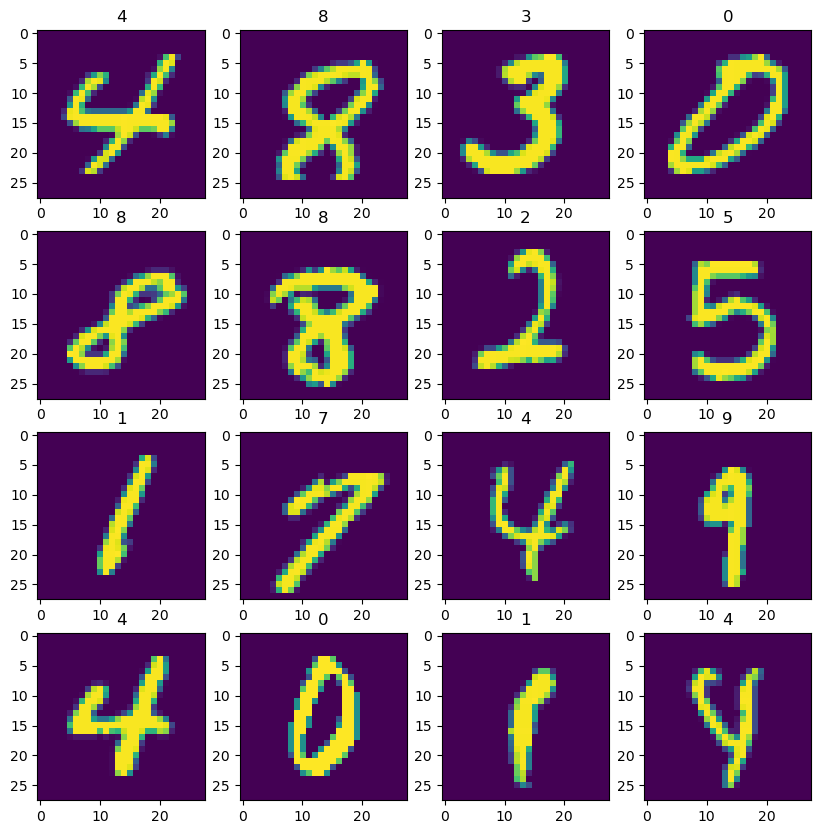

In [6]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
random.seed(10)
indices = random.sample(range(len(X)), 16)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)    # the number of images in the grid is 4*4 (16)
    plt.imshow(X[indices[i]].reshape(28,28))
    plt.title(y[indices[i]].item())

plt.show()

We may use preprocessing techniques such as **PCA, Whitening** on the dataset, to reduce dimesionality and standardizing the data to have unit variance along principal eigen vectors. Here the number of features are 784 per image. We can choose to reduce the dimensionality to significantly lower numbers to ease computation and avoid overfitting. Here, we find we find good enough results without doing any of these.

Following is for the sake of future reference(for myself):

Here are a few factors to consider when deciding whether to use PCA and whitening before training a model:

**Dimensionality of the data**: If the data has a large number of features, using PCA to reduce the dimensionality of the data can help to improve the performance of the model by reducing the complexity of the problem and removing redundant features.

**Correlation between features**: If the features in the data are highly correlated, using PCA to decorrelate the features can help to improve the performance of the model by reducing the redundancy in the data.

**Noise in the data**: If the data is contaminated with noise, using PCA to remove noise from the data can help to improve the performance of the model by reducing the sensitivity of the model to small variations in the input data.

**Model complexity**: If the model is highly complex, using PCA and whitening to reduce the dimensionality and decorrelate the features of the data can help to improve the generalization performance of the model by reducing overfitting.

Overall, whether or not to use PCA and whitening before training a model depends on the specific characteristics of the data and the goals of the model. It may be useful to experiment with different pre-processing techniques and evaluate the performance of the model to determine the best approach for your particular problem.

## Building model using ```nn.Module```
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


<b>Does more layers mean a better model?</b>

Not necessarily. In general, adding more layers to a neural network model can improve its ability to learn and represent complex patterns in the data. However, there is a trade-off between model complexity and performance. If the model is too complex, it can suffer from overfitting, which means it performs well on the training data but poorly on new, unseen data. On the other hand, if the model is too simple, it may not be able to learn the underlying patterns in the data and will perform poorly on both the training and test data.

Therefore, it is important to find the right balance between model complexity and performance. This can often be achieved through techniques such as regularization, which helps to prevent overfitting by adding constraints to the model, or through techniques such as cross-validation, which can help to tune the model's hyperparameters and find the optimal model architecture.


In [7]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(784, 256, bias = False)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        return x

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [8]:
def train(model, optimizer, criterion, train_loader, batch_size, display_step=None, printing = False):
    i = 0 # counts the number of iterations
    roc_auc_test_list = [] # list of roc_auc_scores over test data after every display_step number of minibatches
    roc_auc_validation_list = [] # list of roc_auc_scores over validation data after every display_step number of minibatches
    training_loss_list = [] # list of training loss over training data after every display_step number of minibatches
    accuracy_test_list = [] # list of accuracy scores over test data after every display_step number of minibatches
    accuracy_validation_list = [] # list of accuracy scores over validation data after every display_step number of minibatches
    
    running_loss = 0 #Accumulates loss over display_step number of minibatches
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad() # To avoid accumulation of gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() # Backpropagation
        i += 1
        
        running_loss += loss.item()
        
        if(display_step): 
            if(i%display_step == 0):  
                training_loss_list.append(running_loss/display_step)
                roc_auc_test_list.append(accuracy(predict(model, X_testing.numpy()), y_testing.numpy()))
                roc_auc_validation_list.append(accuracy(predict(model, X_valid.numpy()), y_valid.numpy()))
                accuracy_test_list.append(accuracy2(predict2(model, X_testing.numpy()), y_testing.numpy()))
                accuracy_validation_list.append(accuracy2(predict2(model, X_valid.numpy()), y_valid.numpy()))
                
                # Print values after every display_step number of minibatches
                if(printing):
                    print(f"Training Loss at {i}/{45000/batch_size} mini-batches: {running_loss/display_step}")
                    print(f"ROC-AUC Score on Validation Data at {i}/{45000/batch_size} mini-batches: {accuracy(predict(model, X_valid.numpy()), y_valid.numpy())}")
                    print(f"Accuracy Score on Validation Data at {i}/{45000/batch_size} mini-batches: {accuracy2(predict2(model, X_valid.numpy()), y_valid.numpy())} ")
                    print(f"ROC-AUC Score on Test Data at {i}/{45000/batch_size} mini-batches: {accuracy(predict(model, X_testing.numpy()), y_testing.numpy())}")
                    print(f"Accuracy Score on Test Data at {i}/{45000/batch_size} mini-batches: {accuracy2(predict2(model, X_testing.numpy()), y_testing.numpy())}\n")
                running_loss = 0     
    return [training_loss_list,roc_auc_test_list,roc_auc_validation_list,accuracy_test_list,accuracy_validation_list]

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [9]:
# Predicts predicted scores of the categories
@torch.no_grad()
def predict(model, X_test):
    preds = model(torch.from_numpy(X_test)).detach().numpy()
    preds[preds<0] = 0
    for pred in preds:
        total = pred.sum()
        if(total == 0): 
            print('Weird!')
        else:
            pred /= total
    return preds

In [10]:
# Predicts the category with highest score
@torch.no_grad()
def predict2(model, X_test):
    preds = model(torch.from_numpy(X_test)).detach().numpy()
    preds[preds<0] = 0
    return preds.argmax(axis=1)

In [11]:
# Calculating roc_auc_score
def accuracy(pred, labels):
    return roc_auc_score(labels, pred, average="macro", multi_class="ovr")

In [12]:
# Calculating accuracy score
def accuracy2(pred, labels):
    return accuracy_score(labels, pred)

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


**We use CrossEntropyLoss criterion**

Below for future reference:

To understand how cross-entropy loss works, let's consider a  trinary class classification problem with three classes (labeled 0, 1, and 2), the cross-entropy loss can be calculated using a similar approach as for a binary classification problem.

For each example, we would have a predicted probability distribution over the three classes (p0, p1, p2), where p0, p1, and p2 represent the predicted probability that the example belongs to class 0, class 1, and class 2, respectively. We would also have a true label y that indicates the true class of the example.

The cross-entropy loss for a single example would be calculated as:

Loss = -(log(p0) if y=0) - (log(p1) if y=1) - (log(p2) if y=2)

The total cross-entropy loss for the entire dataset would be calculated as the average of the losses for each example:

Total Loss = (1/N) * sum(Loss)

**We define a custom PyTorch Dataset class called ```MyDataset```. This class can be used to represent a dataset in PyTorch that consists of input examples and corresponding labels.**

The `__init__` method is a special method in Python classes that is called when an instance of the class is created. It is used to initialize the attributes of the instance. In this case, the `__init__` method takes two arguments, `inputs` and `labels`, which represent the input examples and corresponding labels in the dataset, respectively. These are stored as attributes of the `MyDataset` instance.

The `__len__` method is another special method in Python classes that is called when the built-in `len` function is applied to an instance of the class. It should return the length of the dataset, which is the number of examples in the dataset.

The `__getitem__` method is another special method in Python classes that is called when an instance of the class is indexed (e.g., `dataset[i]`). It should return the i-th example and label in the dataset.

By implementing these three special methods, the MyDataset class can be used as a standard PyTorch dataset, allowing it to be used with the other PyTorch data loading and processing tools, such as the `DataLoader` class.

In [13]:
random.seed(10)

model = Net() # Initialising a model
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent Optimiser
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss criterion

# Dataset Class to aid wrapping into a DataLoader
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]


dataset = MyDataset(X_train, y_train)

#training over different batch sizes
y_list = [train(model, optimiser, criterion, DataLoader(dataset, batch_size = batch_size, shuffle = True), batch_size, 300) for batch_size in [15,20,25,30,35]]
x = [300,600,900,1200,1500,1800,2100,2400,2700,3000]

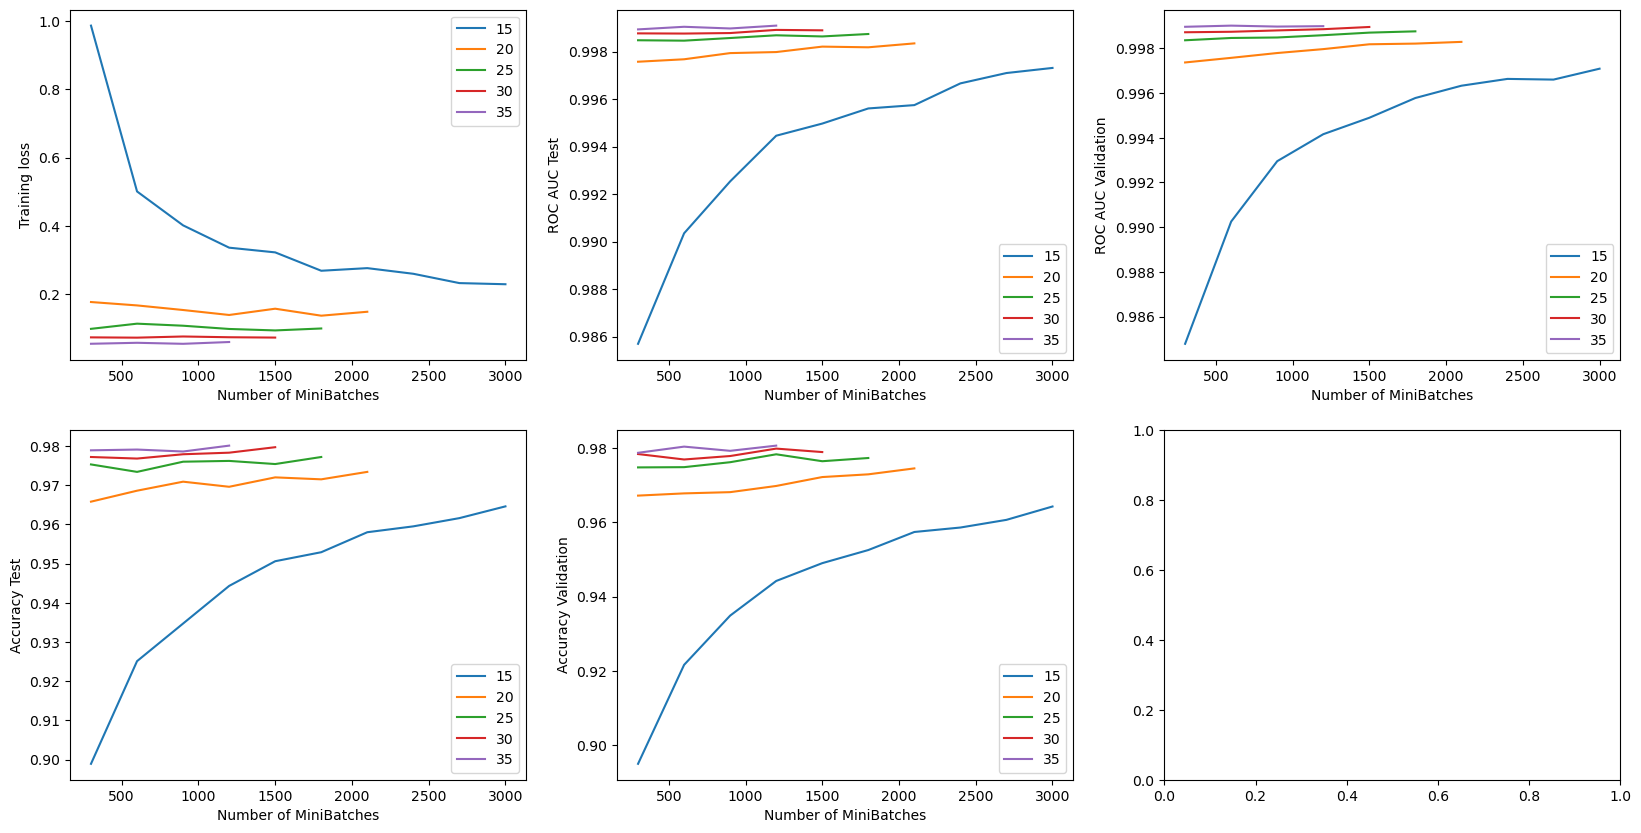

In [14]:
# Plotting graphs of accuracy scores, training loss vs number of minibatches(for different batch sizes)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for y in y_list:
    ax[0][0].plot(x,y[0] + [np.nan] * (10 - len(y[0])))
    ax[0][1].plot(x,y[1] + [np.nan] * (10 - len(y[1])))
    ax[0][2].plot(x,y[2] + [np.nan] * (10 - len(y[2])))
    ax[1][0].plot(x,y[3] + [np.nan] * (10 - len(y[3])))
    ax[1][1].plot(x,y[4] + [np.nan] * (10 - len(y[4])))
    
ylabel_list = ['Training loss', 'ROC AUC Test','ROC AUC Validation','Accuracy Test', 'Accuracy Validation']
i = 0
for ax in [ax[0][0],ax[0][1],ax[0][2],ax[1][0],ax[1][1]]:
    ax.legend(['15','20','25','30','35'])
    ax.set_xlabel('Number of MiniBatches')
    ax.set_ylabel(ylabel_list[i])
    i += 1
    
plt.show()

# Upon examining the plots, we decide to choose batch_size = 20, we find monotonic data, whereas for values > 20, values are almost same and not much improvement is observed

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [15]:
preds = predict(model, X_valid.numpy())
accuracy(preds, y_valid.numpy())
# Very good performance on roc-auc

0.9989299909709022

**For future reference:**

Use cross-validation to tune hyperparameters: We can use techniques such as k-fold cross-validation to tune the hyperparameters of the model, such as the learning rate and the regularization strength. This can help us to find the optimal settings for the model and improve its performance on the dataset.

**But here luckily we have got very good results. Hence we don't require any hyperparameter tuning.**

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

### Final Model

In [16]:
print(Xnew.shape)
print(ynew.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [17]:
random.seed(10)

final_model = Net()
optimiser = optim.SGD(final_model.parameters(), lr=0.001, momentum=0.9)
batch_size = 20
dataset_new = MyDataset(Xnew, ynew)
dataloader = DataLoader(dataset_new, batch_size = batch_size, shuffle = True)
values = train(final_model, optimiser, criterion, dataloader, batch_size, 300, True)

Training Loss at 300/2250.0 mini-batches: 0.9454249411821365
ROC-AUC Score on Validation Data at 300/2250.0 mini-batches: 0.9867284640562912
Accuracy Score on Validation Data at 300/2250.0 mini-batches: 0.9028666666666667 
ROC-AUC Score on Test Data at 300/2250.0 mini-batches: 0.9877338286887791
Accuracy Score on Test Data at 300/2250.0 mini-batches: 0.9044

Training Loss at 600/2250.0 mini-batches: 0.4451842894156774
ROC-AUC Score on Validation Data at 600/2250.0 mini-batches: 0.9908065288929782
Accuracy Score on Validation Data at 600/2250.0 mini-batches: 0.9261333333333334 
ROC-AUC Score on Test Data at 600/2250.0 mini-batches: 0.9912142225782711
Accuracy Score on Test Data at 600/2250.0 mini-batches: 0.9288

Training Loss at 900/2250.0 mini-batches: 0.350651455471913
ROC-AUC Score on Validation Data at 900/2250.0 mini-batches: 0.9932184247282493
Accuracy Score on Validation Data at 900/2250.0 mini-batches: 0.9377333333333333 
ROC-AUC Score on Test Data at 900/2250.0 mini-batches: 0

### Saving the model weights and checking accuracy on testing data

In [18]:
# I work on Jupyter Notebook

# from google.colab import files
torch.save(final_model, 'ass_2.pt')
# files.download('ass_2.pt') # download the file from the Colab session for submission

Check if it got saved right!

In [19]:
# load the model from ass_2.pt
loaded_model = torch.load('ass_2.pt')

# Check if the loaded and final model are the same
tensor1 = {}
tensor2 = {}
for key, value in loaded_model.state_dict().items():
    tensor1[key] = value
for key, value in final_model.state_dict().items():
    tensor2[key] = value

# Compare the tensors
equal = True
for key in tensor1.keys():
    equal = equal and torch.allclose(tensor1[key], tensor2[key])
print(equal)

True


In [20]:
# Predict labels on testing data

predictions = predict(loaded_model, X_testing.numpy())
print('ROC-AUC score:',accuracy(predictions, y_testing.numpy()))
labels = predict2(loaded_model, X_testing.numpy())
print('Accuracy score:',100*accuracy2(labels, y_testing.numpy()))

ROC-AUC score: 0.9973203526636931
Accuracy score: 96.41999999999999
